In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve

def pm(m, g):
    if m < 1:
        raise ValueError("Mach number must be >= 1")
    else:
        nu = math.sqrt((g+1)/(g-1))*math.atan(math.sqrt((g-1)/(g+1)*(m**2-1)))-math.atan(math.sqrt(m**2-1))
        return math.degrees(nu) 

def inverse_pm(nu, g):
    nu = np.radians(nu)
    def equation(m):
            term1 = np.sqrt((g+1)/(g-1))*np.arctan(np.sqrt((g-1)*(m**2-1)/(g+1)))
            term2 = np.arctan(np.sqrt(m**2 - 1))
            return term1 - term2 - nu
    msol = fsolve(equation, 2)
    return msol[0]

def sin_inverse(x):
    return np.degrees(np.arcsin(x))

def tan_inverse(x):
    return np.tan(np.radians(x))

# all these functions are used to calculate for the upper half of the nozzle, results can be mirrored about x axis on lower half as it is symmetric abt x axis
def char_line_quantities(n_cl, Q_initial, Q_delta, g ):
    Q_n = np.zeros((n_cl, n_cl))
    nu_n = np.zeros((n_cl, n_cl))
    M_n = np.zeros((n_cl, n_cl))
    mu_n = np.zeros((n_cl, n_cl))
    K_n = np.zeros((n_cl, n_cl))
    K_p = np.zeros((n_cl, n_cl))

    for i in range(n_cl):  
        for j in range(n_cl - i): 
            if i == 0:  # First Characteristic line
                Q_n[j, i] = Q_initial+j*Q_delta
                nu_n[j, i] = Q_n[j, i]
                K_n[j, i] = Q_n[j, i]+nu_n[j, i]
                K_p[j, i] = Q_n[j, i]-nu_n[j, i]
            else:  
                K_n[j, i] = K_n[j + 1, i - 1]
                if j == 0:  # Centerline
                    K_p[j, i] = -K_n[j, i]
                    Q_n[j, i] = 0
                    nu_n[j, i] = K_n[j, i]
                else:  # Internal Points (j > 0)
                    K_p[j, i] = K_p[j-1, i]
                    Q_n[j, i] = (K_n[j+1, i-1]+K_p[j-1, i]) * 0.5
                    nu_n[j, i] = (K_n[j+1, i-1]-K_p[j-1, i]) * 0.5
            M_n[j, i] = inverse_pm(nu_n[j, i], g)
            mu_n[j, i] = sin_inverse(1/M_n[j, i])
    return Q_n, nu_n, M_n, mu_n, K_n, K_p

def char_line_coordinates(n_cl, Q_n, mu_n, x_ini, y_ini):
    x_n = np.zeros((n_cl, n_cl))
    y_n = np.zeros((n_cl, n_cl))
    for i in range(n_cl):  
        for j in range(n_cl - i):  
            if i == 0: # first characteristic line
                a = Q_n[j, i]-mu_n[j, i]
                if j == 0:
                    b = 0
                    x_n[j, i] = (y_ini-tan_inverse(a)*x_ini)/(tan_inverse(b)-tan_inverse(a))
                    y_n[j, i] = 0
                else:  
                    a = Q_n[j, i] - mu_n[j, i]
                    b = (Q_n[j, i]+Q_n[j-1, i])*0.5 + (mu_n[j, i]+mu_n[j-1, i])*0.5
                    num = (y_ini-tan_inverse(a)*x_ini-y_n[j-1, i]+tan_inverse(b)*x_n[j-1, i])
                    den = tan_inverse(b)-tan_inverse(a)
                    x_n[j, i] = num/den
                    y_n[j, i] = tan_inverse(b)*(x_n[j, i]-x_n[j-1, i])+y_n[j-1, i]
            else:
                if j == 0:  # Centerline
                    a = (Q_n[j+1, i-1]+Q_n[j, i])*0.5-(mu_n[j+1, i-1]+mu_n[j, i])*0.5
                    b = 0
                    x_n[j, i] = (y_n[j+1, i-1]-tan_inverse(a)*x_n[j+1, i-1])/(tan_inverse(b)-tan_inverse(a))
                    y_n[j, i] = 0
                else:  # intern points 
                    a = (Q_n[j+1, i-1]+Q_n[j, i])*0.5-(mu_n[j+1, i-1]+mu_n[j, i])*0.5
                    b = (Q_n[j-1, i]+Q_n[j, i])*0.5+(mu_n[j-1, i]+mu_n[j, i])*0.5
                    num = y_n[j+1, i-1]-tan_inverse(a)*x_n[j+1, i-1]-y_n[j-1, i]+tan_inverse(b)*x_n[j-1, i]
                    den = tan_inverse(b)-tan_inverse(a)
                    x_n[j, i] = num/den
                    y_n[j, i] = tan_inverse(b)*(x_n[j, i]-x_n[j-1, i])+y_n[j-1, i]

    return x_n, y_n

def wall_coordinates(n_cl, x_ini, y_ini, theta_max, Q_n, mu_n, x_n, y_n):
    xw = np.zeros(n_cl+1)
    yw = np.zeros(n_cl+1)
    theta_wall = np.zeros(n_cl+1)
    xw[0] = x_ini
    yw[0] = y_ini
    theta_wall[0] = theta_max
    for i in range(1, n_cl+1):
        if i == 1:
            A = theta_wall[0]
        else:
            A = (Q_n[n_cl-i+1, i-2]+Q_n[n_cl-i, i-1])*0.5
        B = Q_n[n_cl-i, i-1]+mu_n[n_cl-i, i-1]
        num = (yw[i-1]-tan_inverse(A)*xw[i-1]-y_n[n_cl-i, i-1]+tan_inverse(B)*x_n[n_cl-i, i-1]) 
        den = tan_inverse(B)-tan_inverse(A)
        xw[i] = num/den
        yw[i] = tan_inverse(A)*(xw[i]-xw[i-1])+yw[i-1]
    return xw, yw

In [13]:
m_exit = 2.5      
g = 1.4     
n_cl = 50   # Number of C_ characteristic lines (or C+ characteristic lines)
x_ini = 0
y_ini = 1

Q_max = pm(m_exit, g)*0.5
Q_initial = 0.1*Q_max
Q_delta = (Q_max-Q_initial)/(n_cl-1)

Q_n, nu_n, M_n, mu_n, K_n, K_p = char_line_quantities(n_cl, Q_initial, Q_delta, g)
x_n, y_n = char_line_coordinates(n_cl, Q_n, mu_n, x_ini, y_ini)
xw, yw = wall_coordinates(n_cl, x_ini, y_ini, Q_max, Q_n, mu_n, x_n, y_n)

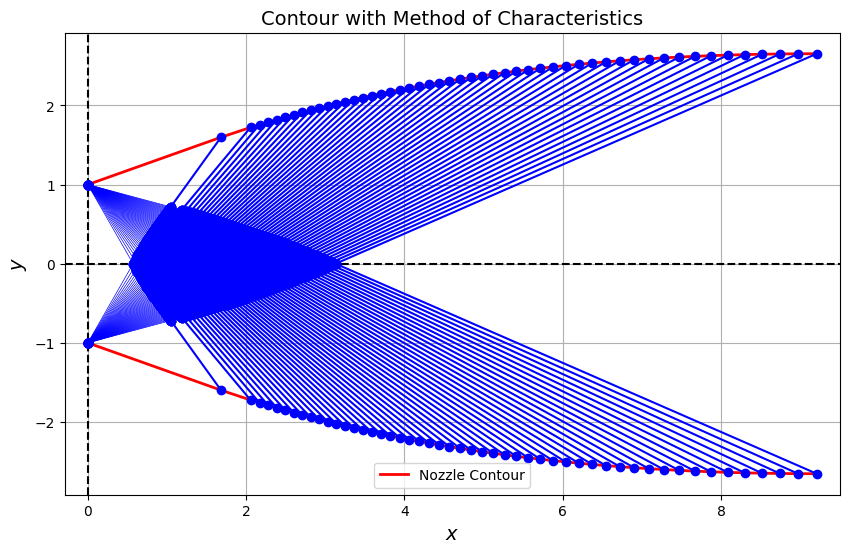

In [14]:
import matplotlib.pyplot as plt

def plot_nozzle_contour(xw, yw):
    plt.plot(xw, yw, 'r-', linewidth=2, label="Nozzle Contour")
    plt.plot(xw, -yw, 'r-', linewidth=2)
    plt.axhline(0, color='k', linestyle='--')
    plt.axvline(0, color='k', linestyle='--')
    plt.grid(True)

def plot_characteristic_lines(x_ini, y_ini, x_n, y_n, n_cl):
    for i in range(n_cl):
        plt.plot([x_ini, x_n[i, 0]], [y_ini, y_n[i, 0]], 'b-o', linewidth=0.5)
        plt.plot([x_ini, x_n[i, 0]], [-y_ini, -y_n[i, 0]], 'b-o', linewidth=0.5) # shape is symmetric so lower half can be plotted by mirroring about x axis
    for i in range(n_cl - 1):
        plt.plot(x_n[0:n_cl-i, i], y_n[0:n_cl-i, i], 'b-o', linewidth=0.5)
        plt.plot(x_n[0:n_cl-i, i], -y_n[0:n_cl-i, i], 'b-o', linewidth=0.5) # shape is symmetric so lower half can be plotted by mirroring about x axis

def plot_inner_nodes(x_n, y_n, n_cl):
    for i in range(n_cl):
        for j in range(1, n_cl - i):
            plt.plot([x_n[j,i], x_n[j-1, i+1]], [y_n[j, i], y_n[j-1, i+1]], 'b-o', linewidth=0.5) # shape is symmetric so lower half can be plotted by mirroring about x axis
            plt.plot([x_n[j,i], x_n[j-1, i+1]], [-y_n[j, i], -y_n[j-1, i+1]], 'b-o', linewidth=0.5) # shape is symmetric so lower half can be plotted by mirroring about x axis

def plot_wall_nodes(xw, yw, x_n, y_n, n_cl):
    for i in range(1, n_cl + 1):
        plt.plot([xw[i], x_n[n_cl-i,i-1]], [yw[i], y_n[n_cl-i, i-1]], 'b-o') # shape is symmetric so lower half can be plotted by mirroring about x axis
        plt.plot([xw[i], x_n[n_cl-i,i-1]], [-yw[i], -y_n[n_cl-i, i-1]], 'b-o') # shape is symmetric so lower half can be plotted by mirroring about x axis

def plot_full_contour(xw, yw, x_ini, y_ini, x_n, y_n, n_cl):
    plt.figure(figsize=(10, 6))
    plot_nozzle_contour(xw, yw)
    plot_characteristic_lines(x_ini, y_ini, x_n, y_n, n_cl)
    plot_inner_nodes(x_n, y_n, n_cl)
    plot_wall_nodes(xw, yw, x_n, y_n, n_cl)
    plt.title('Contour with Method of Characteristics', fontsize=14)
    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$y$', fontsize=14)
    plt.xlim([x_ini - 0.5, max(xw)])
    plt.ylim([y_ini - 1.0, max(yw)])
    plt.axis('equal')
    plt.legend()
    plt.show()

plot_full_contour(xw, yw, x_ini, y_ini, x_n, y_n, n_cl)

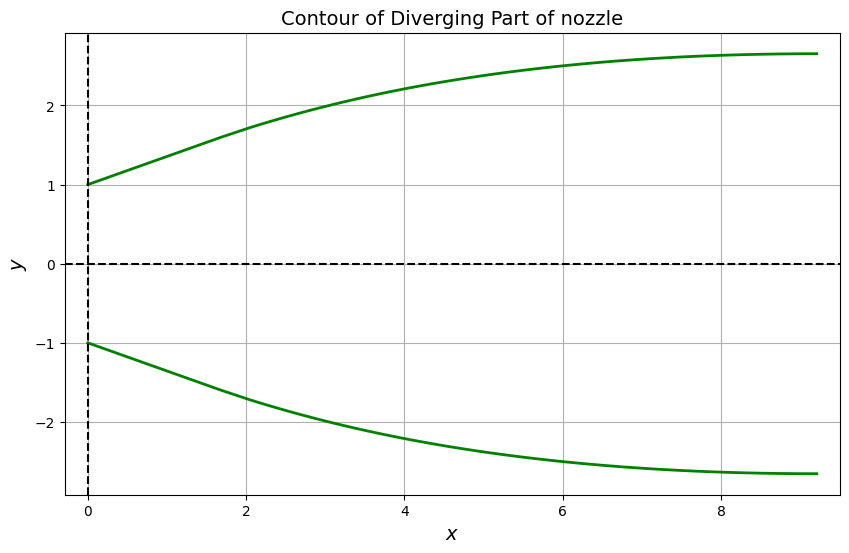

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wall_contour(xw, yw, x_ini, y_ini):
    plt.figure(figsize=(10, 6))
    plt.plot(xw, yw, 'g', linewidth=2)
    plt.plot(xw, -yw, 'g', linewidth=2) # shape is symmetric so lower half can be plotted by mirroring about x axis
    plt.axhline(0, color='k', linestyle='--')
    plt.axvline(0, color='k', linestyle='--')
    plt.grid(True)
    plt.title('Contour of Diverging Part of nozzle', fontsize=14)
    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$y$', fontsize=14)
    plt.xlim([x_ini - 0.5, max(xw)])
    plt.ylim([y_ini - 1.0, max(yw)])
    plt.axis('equal')
    plt.show()
    
plot_wall_contour(xw, yw, x_ini, y_ini)

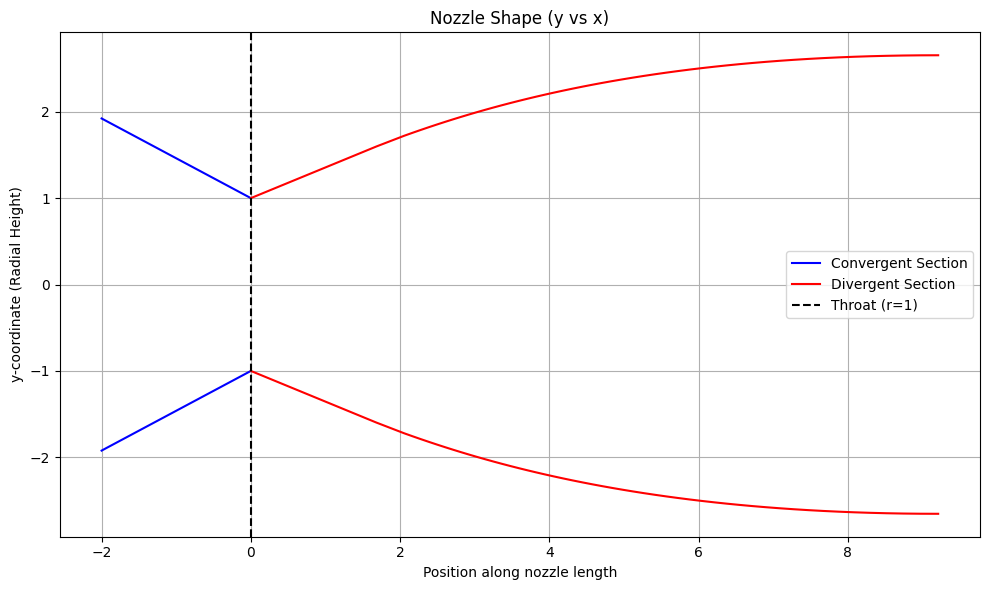

A_inlet/A_throat for Mach 0.32: 1.92
A_exit/A_throat for Mach 2.5: 2.64


In [ ]:
# Now doing it for convergent section of the nozzle
def area_ratio(m, g):
    return (1/m)*((2/(g+1))*(1+(g-1)/2*m**2))**((g+1)/(2*(g-1)))

m_inlet = 0.32   # typical nozzle inlet mach number for rockets is 0.32, from literature
r_throat = 1  # initial assumption (y_ini=1)

Ai_At = area_ratio(m_inlet, g)
Ae_At = area_ratio(m_exit, g)

x_convergent = np.linspace(-2, 0, 51) 
A_converge = np.linspace(Ai_At, 1, 51)  
y_convergent = A_converge

plt.figure(figsize=(10, 6))
plt.plot(x_convergent, y_convergent, 'b-', label="Convergent Section")
plt.plot(x_convergent, -y_convergent, 'b-')  
plt.plot(xw, yw, 'r-', label="Divergent Section")
plt.plot(xw, -yw, 'r-')  
plt.axvline(0, color='k', linestyle='--', label="Throat (r=1)")
plt.xlabel('Position along nozzle length')
plt.ylabel('y-coordinate (Radial Height)')
plt.title('Nozzle Shape (y vs x)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"A_inlet/A_throat for Mach {m_inlet}: {Ai_At:.2f}") # to verify if it is correct
print(f"A_exit/A_throat for Mach {m_exit}: {Ae_At:.2f}") # to verify if it is correct